# Similaridade de Produtos
Aqui implemento a biblioteca Word2Vec e a similaridade dos cossenos para encontrar os produtos mais similares na base.

In [1]:
from gensim.models import Word2Vec
from numpy import mean
from numpy import median
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.metrics.pairwise import cosine_similarity
from warnings import filterwarnings

import matplotlib.pyplot as plt
import re
import seaborn  as sns

In [2]:
filterwarnings('ignore')

## Funções uteis
Aqui temos funções que serão uteis na analise e construção do modelo.

Função que trata o texto, removendo caracteres especiais e transformando em array.

In [3]:
def preprocessing_text(text):
    return re.sub('\s[^\w]\s',  ' ',  re.sub('\s{2,}',  ' ',  text.lower())).split(' ')

Função que a partir de uma frase, faz uma média dos vetores das paralvras dessa frase e gera um vetor para a frase.

In [4]:
def sentence_vector(sentence, model):
    words = [word for word in preprocessing_text(sentence) if word in model.wv.vocab]
    
    if len(words) >= 1:
        return mean(model[words], axis=0).reshape(1, -1)
    else:
        return []

Função que a partir da similaridade dos cossenos, cria uma % de similaridade entre frases

In [5]:
def similarity(sentence1, sentence2, model):
    sv1 = sentence_vector(sentence1, model)
    sv2 = sentence_vector(sentence2, model)
    
    return round(mean((cosine_similarity(sv1, sv2) + 1) / 2) * 100, 2)

## Preparação dos dados


In [6]:
base = read_csv('amazon_co-ecommerce_sample.csv')

In [7]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
uniq_id                                        10000 non-null object
product_name                                   10000 non-null object
manufacturer                                   9993 non-null object
price                                          8565 non-null object
number_available_in_stock                      7500 non-null object
number_of_reviews                              9982 non-null object
number_of_answered_questions                   9235 non-null float64
average_review_rating                          9982 non-null object
amazon_category_and_sub_category               9310 non-null object
customers_who_bought_this_item_also_bought     8938 non-null object
description                                    9349 non-null object
product_information                            9942 non-null object
product_description                            9349 non-null object
items

Irei utilizar a coluna `product_name` para realizar a analise

In [8]:
coluna = 'product_name'

Entendendo a distribuição da quantidade de palavras para ajudar definir qual a janela ideal de palavras no modelo.

Média: 54.18
Mediana: 50.00
Maximo: 536.00
Minimo: 3.00


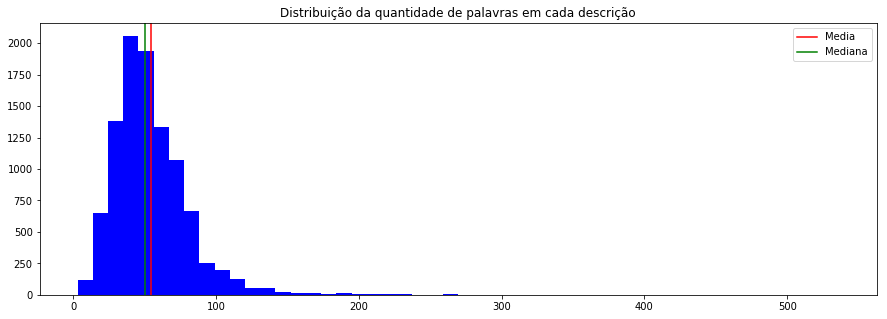

In [9]:
lista_qtd_palavras = base[coluna].str.len()

print('Média: %.2f' % mean(lista_qtd_palavras))
print('Mediana: %.2f' % median(lista_qtd_palavras))
print('Maximo: %.2f' % max(lista_qtd_palavras))
print('Minimo: %.2f' % min(lista_qtd_palavras))

plt.figure(figsize=[15, 5])

plt.axvline(x=mean(lista_qtd_palavras), color='red')
plt.axvline(x=median(lista_qtd_palavras), color='green')

plt.title('Distribuição da quantidade de palavras em cada descrição')
plt.hist(lista_qtd_palavras, bins=50, color='blue')
plt.legend(['Media','Mediana'])

plt.show()

Transformando a base em uma base que serve de input para o modelo.

In [10]:
base_treino = base[coluna].apply(preprocessing_text)
base_treino = list(base_treino)

## Treinando e testando o modelo
Vamos gerar o dicionario treinando o modelo para podermos ter a similaridade dos produtos

In [11]:
model = Word2Vec(base_treino, window=20, size=150)
model.train(base_treino, total_examples=len(base_treino), epochs=100)

(5881548, 8524100)

Aqui vamos utilizar os 15 primeiros produtos e utilizando o modelo treinado vamos definir a similaridade entre eles

In [12]:
base_similaridade = base[coluna].head(15)
matrix_similarity = DataFrame()
a = 0

for i in base_similaridade:
    serie_similaridade = []
    
    for j in base_similaridade:
        serie_similaridade.append(similarity(i, j, model))
    
    matrix_similarity[a] = serie_similaridade    
    a += 1

0 - Hornby 2014 Catalogue
1 - FunkyBuys® Large Christmas Holiday Express Festive Train Set (SI-TY1017) Toy Light / Sounds / Battery Operated & Smoke
2 - CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT ENGINE BOXED BOYS KIDS BATTERY
3 - HORNBY Coach R4410A BR Hawksworth Corridor 3rd
4 - Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam Locomotive Model
5 - 20pcs Model Garden Light Double Heads Lamppost Scale 1:100
6 - Hornby 00 Gauge 230mm BR Bogie Passenger Brake Coach Model (Red)
7 - Hornby Santa's Express Train Set
8 - Hornby Gauge Western Express Digital Train Set with eLink and TTS Loco Train Set
9 - Learning Curve Chuggington Interactive Chatsworth
10 - Hornby Gauge Railroad Mosley Tarmacadam Locomotive
11 - Kato (USA) 176-1308 F3B Denver & Rio Grande Western
12 - Bachmann 37-662 14 Ton Tank Wagon Pease & Partners Red
13 - Hornby 00 Gauge 253mm Weathered Paviland Grange Steam Locomotive Train Model
14 - Kato 3060-2 EF65 500 (F Model) Electric Locomotive


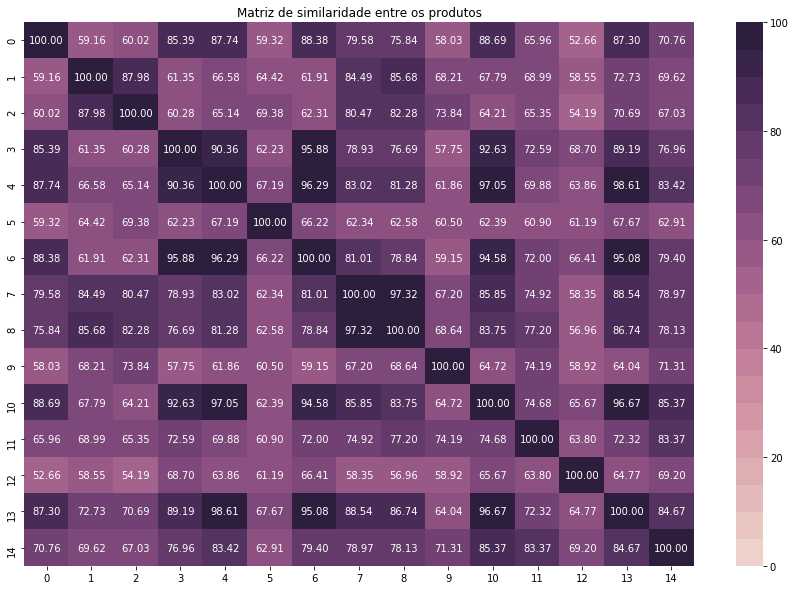

In [13]:
a = 0
for produto in base_similaridade:
    print(str(a) + ' - ' + produto)
    a += 1

plt.figure(figsize=(15, 10))

sns.heatmap(matrix_similarity, annot=True, fmt='.2f', vmax=100, vmin=0, cmap=sns.cubehelix_palette(20))

plt.title('Matriz de similaridade entre os produtos')
plt.show()